In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
onfleet = pd.read_csv("export.csv")
database = pd.read_csv("replate.csv")
database = database.drop("Id", axis = 1)
database = database.rename(index = str, columns = {"Description": "pounds", 
                                           "Scheduled date": "date",
                                          "City [Location]": "city", 
                                           "State [Location]": "state",
                                          "Number [Location]": "number", 
                                           "Addr name [Location]": "company",
                                          "Street [Location]": "street"})
#ignore dropoffs 
onfleet = onfleet[onfleet["pickupTask"] == True]
onfleet = onfleet[["shortId"]]
merged = database.merge(onfleet, left_on = "Short", right_on = "shortId", how = "left")
merged = merged[merged["shortId"].isnull()]

In [159]:
merged = database.merge(onfleet, left_on = "Short", right_on = "shortId", how = "left")
merged = merged[merged["shortId"].isnull()]
locations = pd.read_csv("location.csv")
locations = locations[["Id", "Company name [Business]"]]
ignore = ['Test_Leannon-Kutch', "Billy Bob's Company", 'Test X', 'Testtttttt',
'Pepperdine University ', 'Pepperdine University',
'Test Testing', 'Test company', 'Ryan Hofrichter',
'San Diego Food System Alliance (test sign up)', 
'SDFSA Test', 'Test', 'Lemke, Bernhard and Casper', 'Russel, Little and Cummerata',
'Rippin-Vandervort', 'J.O.N.A.H. INC', "Emily's Company", "Cherry"]

merged = merged.merge(locations, left_on = "Id [Location]", right_on = "Id", how = "left")
merged = merged[~merged["Company name [Business]"].isin(ignore)]
merged["date"] = pd.to_datetime(merged["date"])
merged = merged.drop(["Short", "Id [Location]", "company", "Id"], axis = 1)
merged.loc[merged["pounds"] == ' - ', "pounds"] = "0"
merged.loc[merged["pounds"] == 'Late cancellation', "pounds"] = "0"
merged.loc[merged["pounds"] == 'Requested and immediately canceled over Intercom. Fee not charged. ', "pounds"] = "0"
merged.loc[merged["pounds"] ==  'No data provided or received ', "pounds"] = "0"
merged["month"] = merged["date"].dt.month
merged["day"] = merged["date"].dt.day
merged["year"] = merged["date"].dt.year
days = np.array(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", 
                 "Saturday", "Sunday"])
weekday = []
for i in merged["date"]: 
    weekday.append(i.weekday())
weekday = np.array(weekday)
merged["weekday"] = days[weekday]
splitted = merged["pounds"].str.extractall("(\d*\.?\d*)").unstack()
for col in splitted:
    #convert string to float, otherwise will just be nan
    splitted[col] = pd.to_numeric(splitted[col], errors = "coerce")
#take the maximum float for each of the inputs 
max_pounds = splitted.fillna(0.0).apply(max, axis = 1)
merged["pounds"] = max_pounds
merged = merged[merged["year"] == 2018]
merged = merged[["Company name [Business]", "pounds", "Status", "Driver", "Paid", "city", "Pickup price [Location]", "month", "weekday"]]

In [160]:
merged.shape

(142, 9)

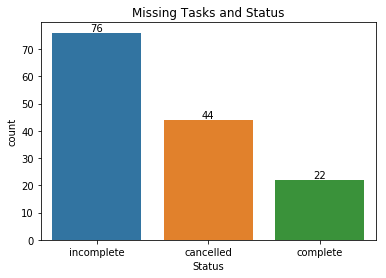

In [166]:
ax = sns.countplot(x = "Status", data = merged);
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

plt.title("Missing Tasks and Status");

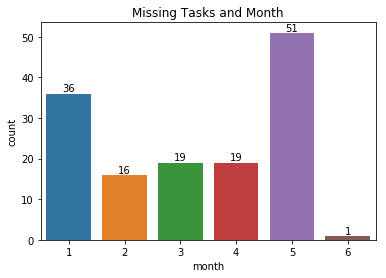

In [223]:
ax = sns.countplot(x = "month", data = merged);
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

plt.title("Missing Tasks and Month");

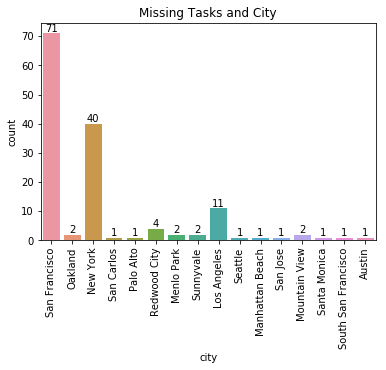

In [224]:
ax = sns.countplot(x = "city", data = merged);
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

plt.title("Missing Tasks and City");

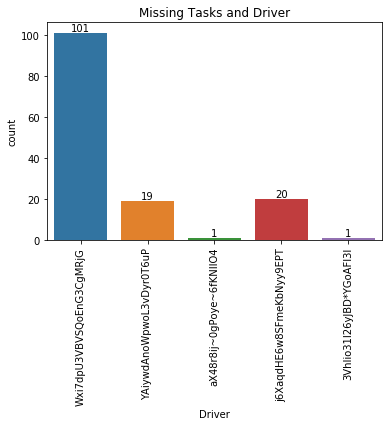

In [225]:
ax = sns.countplot(x = "Driver", data = merged);
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

plt.title("Missing Tasks and Driver");

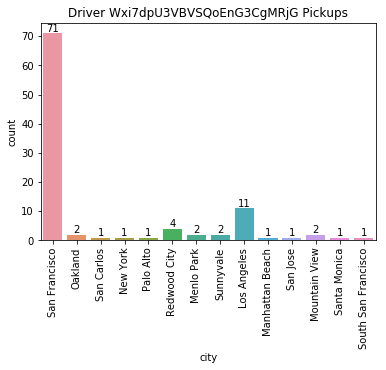

In [221]:
ax = sns.countplot(merged[merged["Driver"] == "Wxi7dpU3VBVSQoEnG3CgMRjG"]["city"])
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

plt.title("Driver Wxi7dpU3VBVSQoEnG3CgMRjG Pickups");

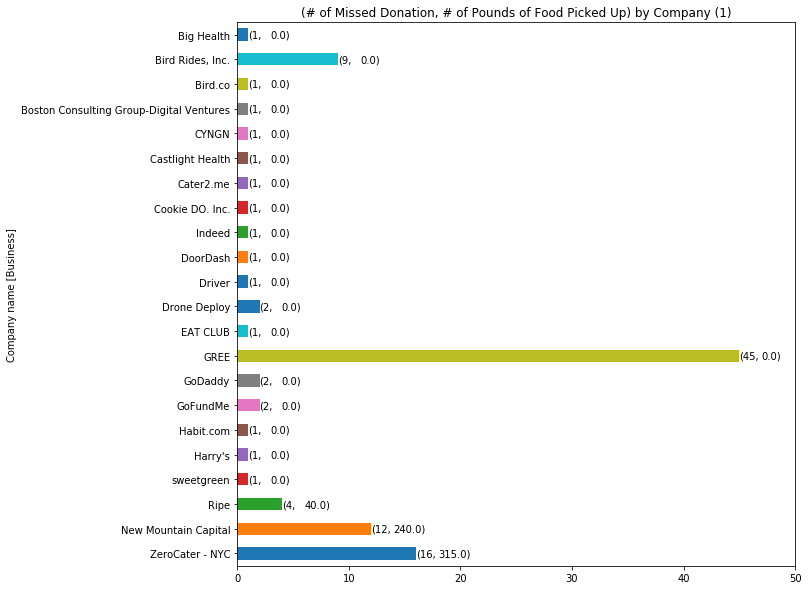

In [228]:
companies_with_complete = merged[(merged["Status"] == "complete") & (merged["Paid"] == False)].groupby("Company name [Business]")["Status"].count().index
merged["complete_status"] = merged["Company name [Business]"].isin(companies_with_complete).astype("int")
merged.groupby("Company name [Business]")["complete_status"].agg(np.sum)merged["complete_status"] = merged["Company name [Business]"].isin(companies_with_complete).astype("int")
company_counts = merged.groupby("Company name [Business]")["Company name [Business]"].count()
company_pounds = merged.groupby("Company name [Business]")["pounds"].agg(np.sum).sort_values(ascending = False)

company_counts = company_counts.reindex(index = company_pounds.index)
ax1 = company_counts[0:22].plot(kind = "barh", figsize = (10, 10), 
                   title = "(# of Missed Donation, # of Pounds of Food Picked Up) by Company (1)")
for a, b in zip(enumerate(company_counts[0:22]), enumerate(company_pounds[0:22])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 2, a[0]), va = "center")
ax1.set_xlim(0, 50);

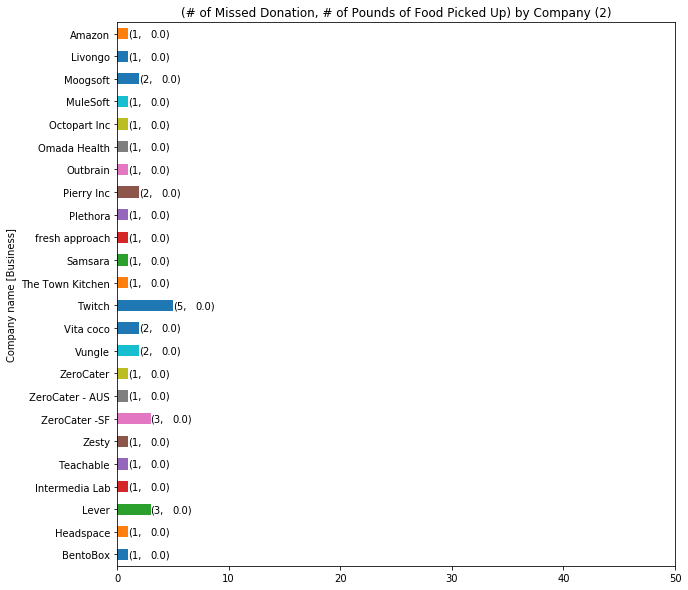

In [198]:
ax1 = company_counts[22:].plot(kind = "barh", figsize = (10, 10), 
                   title = "(# of Missed Donation, # of Pounds of Food Picked Up) by Company (2)")
for a, b in zip(enumerate(company_counts[22:]), enumerate(company_pounds[22:])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 2, a[0]), va = "center")
ax1.set_xlim(0, 50);

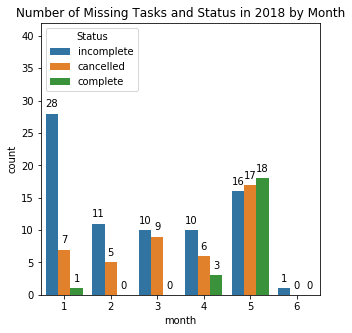

In [130]:
#plt.figure(figsize = (10, 5));
#sns.factorplot(x = "month", hue = "Status", data = merged, kind = "count");
#plt.title("Number of Missing Tasks and Status in 2018 by Month");
import math
#total = float(len(titanic))
plt.figure(figsize = (5, 5))
ax = sns.countplot(x = "month", hue = "Status", data = merged)
#ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
plt.ylim(0, 42)
#plt.figure(figsize = (20, 10))
for p in ax.patches:
    height = p.get_height()
    if math.isnan(float(height)):
        height = 0
    ax.text(p.get_x()+p.get_width()/2,
            height + 1,
            '{:1.0f}'.format(int(height)),
            ha="center")
plt.title("Number of Missing Tasks and Status in 2018 by Month");


In [232]:
merged

,Company name [Business],pounds,Status,Driver,Paid,city,Pickup price [Location],month,weekday,complete_status
384,GREE,0.0,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,False,San Francisco,20,1,Tuesday,0
386,Habit.com,0.0,cancelled,Wxi7dpU3VBVSQoEnG3CgMRjG,False,Oakland,40,1,Wednesday,0
387,Cookie DO. Inc.,0.0,cancelled,YAiywdAnoWpwoL3vDyr0T6uP,False,New York,30,1,Wednesday,0
388,GREE,0.0,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,False,San Francisco,20,1,Thursday,0
389,EAT CLUB,0.0,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,False,San Carlos,20,1,Thursday,0
391,GREE,0.0,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,False,San Francisco,20,1,Tuesday,0
393,GREE,0.0,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,False,San Francisco,20,1,Thursday,0
395,Big Health,0.0,cancelled,Wxi7dpU3VBVSQoEnG3CgMRjG,False,San Francisco,30,1,Thursday,0
396,Twitch,0.0,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,False,San Francisco,20,1,Friday,0
398,GREE,0.0,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,False,San Francisco,20,1,Tuesday,0


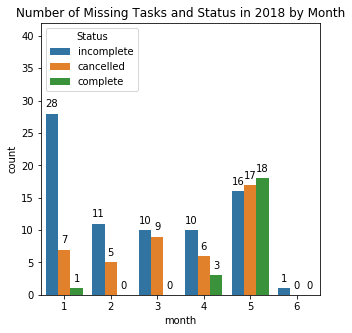

In [231]:
#plt.figure(figsize = (10, 5));
#sns.factorplot(x = "month", hue = "Status", data = merged, kind = "count");
#plt.title("Number of Missing Tasks and Status in 2018 by Month");
import math
#total = float(len(titanic))
plt.figure(figsize = (5, 5))
ax = sns.countplot(x = "month", hue = "Status", data = merged)
#ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
plt.ylim(0, 42)
#plt.figure(figsize = (20, 10))
for p in ax.patches:
    height = p.get_height()
    if math.isnan(float(height)):
        height = 0
    ax.text(p.get_x()+p.get_width()/2,
            height + 1,
            '{:1.0f}'.format(int(height)),
            ha="center")
plt.title("Number of Missing Tasks and Status in 2018 by Month");


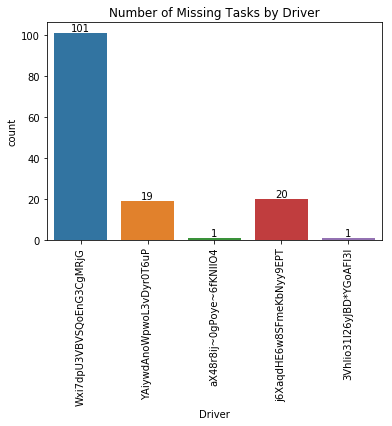

In [147]:
ax = sns.countplot("Driver", data = merged);
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
plt.title("Number of Missing Tasks by Driver");

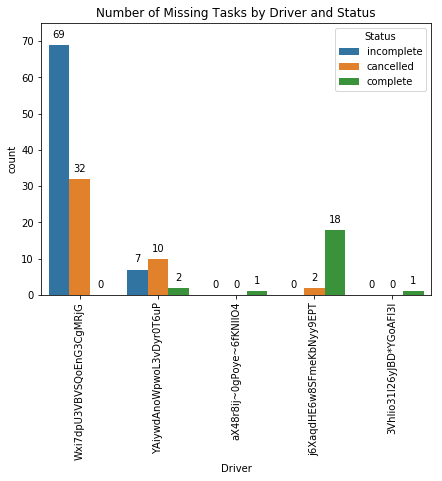

In [142]:
import math
#total = float(len(titanic))
plt.figure(figsize = (7, 5))
ax = sns.countplot(x = "Driver", hue = "Status", data = merged)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
plt.ylim(0, 75)
#plt.figure(figsize = (20, 10))
for p in ax.patches:
    height = p.get_height()
    if math.isnan(float(height)):
        height = 0
    ax.text(p.get_x()+p.get_width()/2,
            height + 2,
            '{:1.0f}'.format(int(height)),
            ha="center")
plt.title("Number of Missing Tasks by Driver and Status");

Text(0.5,1,'Counts of Companies with Completed Pickups')

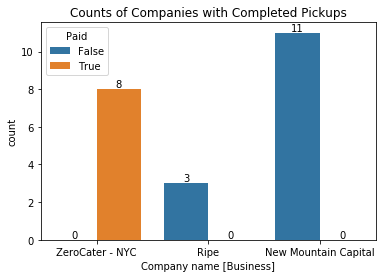

In [248]:
ax = sns.countplot("Company name [Business]", hue = "Paid", data = merged[merged["Status"] == "complete"]);
#ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
#plt.figure(figsize = (20, 10))
for p in ax.patches:
    height = p.get_height()
    if math.isnan(float(height)):
        height = 0
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.1,
            '{:1.0f}'.format(int(height)),
            ha="center")
plt.title("Counts of Companies with Completed Pickups")

In [233]:
companies_with_complete = merged[(merged["Status"] == "complete") & (merged["Paid"] == False)].groupby("Company name [Business]")["Status"].count().index
merged["complete_status"] = merged["Company name [Business]"].isin(companies_with_complete).astype("int")
merged.groupby("Company name [Business]")["complete_status"].agg(np.sum)

Company name [Business]
Amazon                                       0
BentoBox                                     0
Big Health                                   0
Bird Rides, Inc.                             0
Bird.co                                      0
Boston Consulting Group-Digital Ventures     0
CYNGN                                        0
Castlight Health                             0
Cater2.me                                    0
Cookie DO. Inc.                              0
DoorDash                                     0
Driver                                       0
Drone Deploy                                 0
EAT CLUB                                     0
GREE                                         0
GoDaddy                                      0
GoFundMe                                     0
Habit.com                                    0
Harry's                                      0
Headspace                                    0
Indeed                              

In [266]:
for a in enumerate(company_owe):
    print(a[0], a[1])

0 330
1 120


(0, 400)

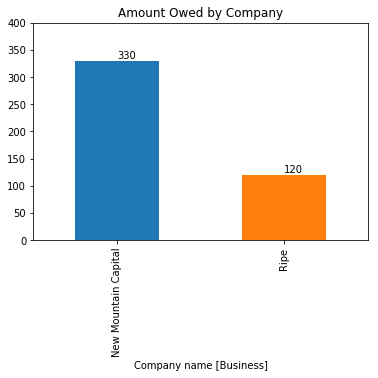

In [271]:
company_owe = merged[(merged["Status"] == "complete") & (merged["Paid"] == False)].groupby("Company name [Business]")["Pickup price [Location]"].agg(np.sum)
ax1 = company_owe.plot(kind = "bar", title = "Amount Owed by Company");
for a in enumerate(company_owe):
    plt.annotate(str(a[1]), xy = (a[0], a[1] + 10), va = "center")
ax1.set_ylim(0, 400)

In [229]:
merged.columns

Index(['Company name [Business]', 'pounds', 'Status', 'Driver', 'Paid', 'city',
       'Pickup price [Location]', 'month', 'weekday', 'complete_status'],
      dtype='object')

In [17]:
merged

,date,Onfleet,Status,Driver,Created at,Updated at,pounds,Trays donated,Paid,Invoice number,...,Pickup price [Location],Plan [Location],Plan exclusive [Location],Photo [Location],shortId,Company name [Business],month,day,year,weekday
384,2018-01-02,*S8LW4u6GCLP58KK~D46J*uJ,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 01, 2018 07:31","January 01, 2018 07:31",0.0,-,False,-,...,20,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,GREE,1,2,2018,Tuesday
386,2018-01-03,MkNiiQkluWfHlhJihjDkWw7K,cancelled,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 02, 2018 07:31","January 02, 2018 17:27",0.0,-,False,-,...,40,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,Habit.com,1,3,2018,Wednesday
387,2018-01-03,cSwWbBkLVQFc3BBZcmg~mplg,cancelled,YAiywdAnoWpwoL3vDyr0T6uP,"January 02, 2018 07:31","January 03, 2018 12:42",0.0,-,False,-,...,30,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,Cookie DO. Inc.,1,3,2018,Wednesday
388,2018-01-04,4wbdFYVNIa8L7Oc8ypfBiM2G,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 03, 2018 07:30","January 03, 2018 07:30",0.0,-,False,-,...,20,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,GREE,1,4,2018,Thursday
389,2018-01-04,ufd2Ls6xelRVrnoUMurrCWg~,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 04, 2018 20:30","January 04, 2018 20:30",0.0,-,False,-,...,20,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,EAT CLUB,1,4,2018,Thursday
391,2018-01-09,iv*k6WJ3Q9JAsApddwWWE4os,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 08, 2018 07:30","January 08, 2018 07:30",0.0,-,False,-,...,20,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,GREE,1,9,2018,Tuesday
393,2018-01-11,H3RuSXeAQQHIgBznfFw~GKBa,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 10, 2018 07:31","January 10, 2018 07:31",0.0,-,False,-,...,20,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,GREE,1,11,2018,Thursday
395,2018-01-11,pcU4smgad7utONq0LzHj95ez,cancelled,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 10, 2018 07:31","January 10, 2018 20:20",0.0,-,False,-,...,30,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,Big Health,1,11,2018,Thursday
396,2018-01-12,qR8HF9hPXZZDjpeJZjUBcceF,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 11, 2018 07:31","January 11, 2018 07:31",0.0,-,False,-,...,20,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,Twitch,1,12,2018,Friday
398,2018-01-16,WfA6xmLeaZtyrCxJjBMIVSQy,incomplete,Wxi7dpU3VBVSQoEnG3CgMRjG,"January 15, 2018 07:31","January 15, 2018 07:31",0.0,-,False,-,...,20,-,False,//s3-us-west-2.amazonaws.com/replate-dev/locat...,NaN,GREE,1,16,2018,Tuesday


In [402]:
merged.to_csv("data_discrepency.csv", sep = ",")